## Goals
- Combine Preprocessor Pipeline with a model
- Select and implement a model
- Evaluate the model
- Save the model for parameter tuning

## Imports

In [1]:
# Basic
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Utilities
import pickle
import os

# Notebook Utilities
%matplotlib inline

In [2]:
## Pipelines
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

## Transformers
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.preprocessing import FunctionTransformer

## Scalers
from sklearn.preprocessing import StandardScaler, MinMaxScaler

## Model
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

## Parameter Tuning
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

## Metrics
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, classification_report

## Functions

In [3]:
# Function which seperates feature types
def data_seperator(data, depend=None):
    # Stores dependant variable
    if depend != None:
        data_depend = data[depend]
        data = data.drop(depend, axis=1)
    else:
        data_depend = []
    
    # Stores categorical features
    select = [data.columns[i] for i in np.where(data.dtypes == 'O')[0]]
    data_categ = pd.DataFrame(data[select])
    
    # Stores all numerical features
    data_num = data.drop(select, axis=1)
    
    # Seperating time features from numerical features
    select = [i for i in data_num.columns if 'year' in i.lower() or 'yr' in i.lower() or 'day' in i or 'week' in i.lower()]
    data_time = pd.DataFrame(data_num[select])
    data_num = data_num.drop(select, axis=1)
    
    # Seperating discrete and continuous features
    select = [feature for feature in data_num if len(data_num[feature].unique()) < 10]
    data_discrete = pd.DataFrame(data_num[select])
    data_continuous = data_num.drop(select, axis=1)
    
    # Returning the features
    return data_num, data_discrete, data_continuous, data_categ, data_time, data_depend

In [4]:
def impute_first_letter(df):
    for i in range(len(df)):
        for x in range(len(df[i])):
            df[i][x] = df[i][x][0]
    return df

## Dataset Information
The sinking of the Titanic is one of the most infamous shipwrecks in history.

On April 15, 1912, during her maiden voyage, the widely considered “unsinkable” RMS Titanic sank after colliding with an iceberg. Unfortunately, there weren’t enough lifeboats for everyone onboard, resulting in the death of 1502 out of 2224 passengers and crew.

While there was some element of luck involved in surviving, it seems some groups of people were more likely to survive than others.

In this challenge, we ask you to build a predictive model that answers the question: “what sorts of people were more likely to survive?” using passenger data (ie name, age, gender, socio-economic class, etc).

- Source: https://www.kaggle.com/competitions/titanic/data
- Use Machine Learning to create a model that predicts which passengers survived the Titanic shipwreck.
- I chose this dataset because it has many types of features. 
- It has features with missing values and outliers
- Overall, I think this is a good dataset for practicing the basics.

## Working Directory

In [5]:
old_path = os.getcwd()
os.chdir('..')
path = os.getcwd()

## Reading Data

In [6]:
data = pd.read_csv('data/raw/train.csv')
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Dropping the Unnecessary Features

In [7]:
data = data.drop(['PassengerId', 'Name', 'Ticket'], axis=1)

## Separating the data
Seperated the data into different variables for ease of access and keeping the original data as backup

In [8]:
data_num, data_discrete, data_continuous, data_categ, data_time, data_depend = data_seperator(data, 'Survived')

In [9]:
data_continuous.head()

,Age,Fare
0,22.0,7.2500
1,38.0,71.2833
2,26.0,7.9250
3,35.0,53.1000
4,35.0,8.0500


## Organizing the Data

In [10]:
data = pd.concat([data_continuous, data_discrete, data_categ, data_time, data_depend], axis=1)

## Preprocessing Piplelines

In [11]:
with open('model/preprocessor.pkl', 'rb') as f:
    preprocessor = pickle.load(f)
preprocessor

ColumnTransformer(transformers=[('Continuous',
                                 Pipeline(steps=[('Imputer', KNNImputer()),
                                                 ('Scaler', MinMaxScaler())]),
                                 Index(['Age', 'Fare'], dtype='object')),
                                ('Discrete',
                                 Pipeline(steps=[('Imputer',
                                                  SimpleImputer(strategy='most_frequent'))]),
                                 Index(['Pclass', 'SibSp', 'Parch'], dtype='object')),
                                ('Categorical',
                                 Pipeline(steps=[('Imputer',
                                                  SimpleImputer(strategy=...
                                 Index(['Sex', 'Embarked'], dtype='object')),
                                ('Cabin',
                                 Pipeline(steps=[('Imputer',
                                                  SimpleImputer(fill_value='N',
                                                                strategy='constant')),
                                                 ('Scaler',
                                                  FunctionTransformer(feature_names_out='one-to-one',
                                                                      func=<function impute_first_letter at 0x0000028AD50E4820>)),
                                                 ('Encoder',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'))]),
                                 array(['Cabin'], dtype='<U5'))],
                  verbose=True)

## Model Pipeline

In [12]:
steps = [('preprocessor', preprocessor), ('classifier', LogisticRegression())]
pipe = Pipeline(steps)

## Train-Test Split

In [13]:
x = data.drop('Survived', axis=1)
y = data.Survived

# Splitting the data into test and train sets
# x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.20, random_state=0)

In [14]:
x_train = x
y_train = y
x_test = pd.read_csv('data/external/new_x_test.csv')
y_test = pd.read_csv('data/external/new_y_test.csv').drop('PassengerId', axis=1)

## Fitting the training values

In [15]:
pipe.fit(x_train, y_train)

[ColumnTransformer] .... (1 of 4) Processing Continuous, total=   0.0s
[ColumnTransformer] ...... (2 of 4) Processing Discrete, total=   0.0s
[ColumnTransformer] ... (3 of 4) Processing Categorical, total=   0.0s
[ColumnTransformer] ......... (4 of 4) Processing Cabin, total=   0.0s


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('Continuous',
                                                  Pipeline(steps=[('Imputer',
                                                                   KNNImputer()),
                                                                  ('Scaler',
                                                                   MinMaxScaler())]),
                                                  Index(['Age', 'Fare'], dtype='object')),
                                                 ('Discrete',
                                                  Pipeline(steps=[('Imputer',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  Index(['Pclass', 'SibSp', 'Parch'], dtype='object')),
                                                 ('Categorical',
                                                  Pipeline(steps=[('...
                                                 ('Cabin',
                                                  Pipeline(steps=[('Imputer',
                                                                   SimpleImputer(fill_value='N',
                                                                                 strategy='constant')),
                                                                  ('Scaler',
                                                                   FunctionTransformer(feature_names_out='one-to-one',
                                                                                       func=<function impute_first_letter at 0x0000028AD50E4820>)),
                                                                  ('Encoder',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  array(['Cabin'], dtype='<U5'))],
                                   verbose=True)),
                ('classifier', LogisticRegression())])

In [16]:
y_pred = pipe.predict(x_test)

## Evaluating the Model

In [17]:
pipe.score(x_train, y_train)

0.8103254769921436

In [18]:
accuracy_score(y_test, y_pred)

0.9401913875598086

In [19]:
f1_score(y_test, y_pred)

0.9201277955271566

Text(0.5, -7.277777777777782, 'Predicted Values')

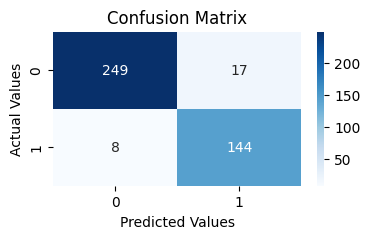

In [20]:
cm = confusion_matrix(y_test,y_pred)
plt.figure(figsize=(4,2))
plt.title("Confusion Matrix")
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.ylabel("Actual Values")
plt.xlabel("Predicted Values")

In [21]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.94      0.95       266
           1       0.89      0.95      0.92       152

    accuracy                           0.94       418
   macro avg       0.93      0.94      0.94       418
weighted avg       0.94      0.94      0.94       418



## Model and Parameters Selection

In [22]:
pipe.get_params()

{'memory': None,
 'steps': [('preprocessor',
   ColumnTransformer(transformers=[('Continuous',
                                    Pipeline(steps=[('Imputer', KNNImputer()),
                                                    ('Scaler', MinMaxScaler())]),
                                    Index(['Age', 'Fare'], dtype='object')),
                                   ('Discrete',
                                    Pipeline(steps=[('Imputer',
                                                     SimpleImputer(strategy='most_frequent'))]),
                                    Index(['Pclass', 'SibSp', 'Parch'], dtype='object')),
                                   ('Categorical',
                                    Pipeline(steps=[('Imputer',
                                                     SimpleImputer(strategy=...
                                    Index(['Sex', 'Embarked'], dtype='object')),
                                   ('Cabin',
                                    Pipeline(st

In [23]:
# Pipeline Parameters
parameters = [
    {
        'classifier': [LogisticRegression(), KNeighborsClassifier(), SVC(), RandomForestClassifier(), AdaBoostClassifier(),
                      DecisionTreeClassifier()],
        
        'preprocessor__Continuous__Scaler': [MinMaxScaler(), StandardScaler(), 
                                             FunctionTransformer(np.log1p, feature_names_out='one-to-one')],
        
        'preprocessor__Categorical__Encoder': [OneHotEncoder(drop='first', handle_unknown='ignore'),
                                               OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=10)],
        
        'preprocessor__Cabin__Encoder': [OneHotEncoder(drop='first', handle_unknown='ignore'),
                                         OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=10)],
        
    }, 
]

In [25]:
grid_search = GridSearchCV(pipe, parameters, cv=5, scoring='accuracy', verbose=3)

In [26]:
grid_search.fit(x_train, y_train)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
[ColumnTransformer] .... (1 of 4) Processing Continuous, total=   0.0s
[ColumnTransformer] ...... (2 of 4) Processing Discrete, total=   0.0s
[ColumnTransformer] ... (3 of 4) Processing Categorical, total=   0.0s
[ColumnTransformer] ......... (4 of 4) Processing Cabin, total=   0.0s
[CV 1/5] END classifier=LogisticRegression(), preprocessor__Cabin__Encoder=OneHotEncoder(drop='first', handle_unknown='ignore'), preprocessor__Categorical__Encoder=OneHotEncoder(drop='first', handle_unknown='ignore'), preprocessor__Continuous__Scaler=MinMaxScaler();, score=0.777 total time=   0.0s
[ColumnTransformer] .... (1 of 4) Processing Continuous, total=   0.0s
[ColumnTransformer] ...... (2 of 4) Processing Discrete, total=   0.0s
[ColumnTransformer] ... (3 of 4) Processing Categorical, total=   0.0s
[ColumnTransformer] ......... (4 of 4) Processing Cabin, total=   0.0s
[CV 2/5] END classifier=LogisticRegression(), preprocessor__Cabin__Enco

F:\Learning\Tools\Installed\Python 3.10.6\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/5] END classifier=LogisticRegression(), preprocessor__Cabin__Encoder=OneHotEncoder(drop='first', handle_unknown='ignore'), preprocessor__Categorical__Encoder=OneHotEncoder(drop='first', handle_unknown='ignore'), preprocessor__Continuous__Scaler=MinMaxScaler();, score=0.792 total time=   0.0s
[ColumnTransformer] .... (1 of 4) Processing Continuous, total=   0.0s
[ColumnTransformer] ...... (2 of 4) Processing Discrete, total=   0.0s
[ColumnTransformer] ... (3 of 4) Processing Categorical, total=   0.0s
[ColumnTransformer] ......... (4 of 4) Processing Cabin, total=   0.0s
[CV 4/5] END classifier=LogisticRegression(), preprocessor__Cabin__Encoder=OneHotEncoder(drop='first', handle_unknown='ignore'), preprocessor__Categorical__Encoder=OneHotEncoder(drop='first', handle_unknown='ignore'), preprocessor__Continuous__Scaler=MinMaxScaler();, score=0.781 total time=   0.0s
[ColumnTransformer] .... (1 of 4) Processing Continuous, total=   0.0s
[ColumnTransformer] ...... (2 of 4) Processing 

F:\Learning\Tools\Installed\Python 3.10.6\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 4/5] END classifier=LogisticRegression(), preprocessor__Cabin__Encoder=OneHotEncoder(drop='first', handle_unknown='ignore'), preprocessor__Categorical__Encoder=OneHotEncoder(drop='first', handle_unknown='ignore'), preprocessor__Continuous__Scaler=StandardScaler();, score=0.775 total time=   0.0s
[ColumnTransformer] .... (1 of 4) Processing Continuous, total=   0.0s
[ColumnTransformer] ...... (2 of 4) Processing Discrete, total=   0.0s
[ColumnTransformer] ... (3 of 4) Processing Categorical, total=   0.0s
[ColumnTransformer] ......... (4 of 4) Processing Cabin, total=   0.0s
[CV 5/5] END classifier=LogisticRegression(), preprocessor__Cabin__Encoder=OneHotEncoder(drop='first', handle_unknown='ignore'), preprocessor__Categorical__Encoder=OneHotEncoder(drop='first', handle_unknown='ignore'), preprocessor__Continuous__Scaler=StandardScaler();, score=0.809 total time=   0.0s
[ColumnTransformer] .... (1 of 4) Processing Continuous, total=   0.0s
[ColumnTransformer] ...... (2 of 4) Process

F:\Learning\Tools\Installed\Python 3.10.6\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[ColumnTransformer] ... (3 of 4) Processing Categorical, total=   0.0s
[ColumnTransformer] ......... (4 of 4) Processing Cabin, total=   0.0s
[CV 4/5] END classifier=LogisticRegression(), preprocessor__Cabin__Encoder=OneHotEncoder(drop='first', handle_unknown='ignore'), preprocessor__Categorical__Encoder=OneHotEncoder(drop='first', handle_unknown='ignore'), preprocessor__Continuous__Scaler=FunctionTransformer(feature_names_out='one-to-one', func=<ufunc 'log1p'>);, score=0.787 total time=   0.0s
[ColumnTransformer] .... (1 of 4) Processing Continuous, total=   0.0s
[ColumnTransformer] ...... (2 of 4) Processing Discrete, total=   0.0s
[ColumnTransformer] ... (3 of 4) Processing Categorical, total=   0.0s
[ColumnTransformer] ......... (4 of 4) Processing Cabin, total=   0.0s
[CV 5/5] END classifier=LogisticRegression(), preprocessor__Cabin__Encoder=OneHotEncoder(drop='first', handle_unknown='ignore'), preprocessor__Categorical__Encoder=OneHotEncoder(drop='first', handle_unknown='ignore')

F:\Learning\Tools\Installed\Python 3.10.6\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 4/5] END classifier=LogisticRegression(), preprocessor__Cabin__Encoder=OneHotEncoder(drop='first', handle_unknown='ignore'), preprocessor__Categorical__Encoder=OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=10), preprocessor__Continuous__Scaler=MinMaxScaler();, score=0.787 total time=   0.0s
[ColumnTransformer] .... (1 of 4) Processing Continuous, total=   0.0s
[ColumnTransformer] ...... (2 of 4) Processing Discrete, total=   0.0s
[ColumnTransformer] ... (3 of 4) Processing Categorical, total=   0.0s
[ColumnTransformer] ......... (4 of 4) Processing Cabin, total=   0.0s
[CV 5/5] END classifier=LogisticRegression(), preprocessor__Cabin__Encoder=OneHotEncoder(drop='first', handle_unknown='ignore'), preprocessor__Categorical__Encoder=OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=10), preprocessor__Continuous__Scaler=MinMaxScaler();, score=0.815 total time=   0.0s
[ColumnTransformer] .... (1 of 4) Processing Continuous, total=   0.0s
[ColumnTransfor

F:\Learning\Tools\Installed\Python 3.10.6\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/5] END classifier=LogisticRegression(), preprocessor__Cabin__Encoder=OneHotEncoder(drop='first', handle_unknown='ignore'), preprocessor__Categorical__Encoder=OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=10), preprocessor__Continuous__Scaler=StandardScaler();, score=0.803 total time=   0.0s
[ColumnTransformer] .... (1 of 4) Processing Continuous, total=   0.0s
[ColumnTransformer] ...... (2 of 4) Processing Discrete, total=   0.0s
[ColumnTransformer] ... (3 of 4) Processing Categorical, total=   0.0s
[ColumnTransformer] ......... (4 of 4) Processing Cabin, total=   0.0s
[CV 3/5] END classifier=LogisticRegression(), preprocessor__Cabin__Encoder=OneHotEncoder(drop='first', handle_unknown='ignore'), preprocessor__Categorical__Encoder=OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=10), preprocessor__Continuous__Scaler=StandardScaler();, score=0.781 total time=   0.0s
[ColumnTransformer] .... (1 of 4) Processing Continuous, total=   0.0s
[ColumnTran

F:\Learning\Tools\Installed\Python 3.10.6\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/5] END classifier=LogisticRegression(), preprocessor__Cabin__Encoder=OneHotEncoder(drop='first', handle_unknown='ignore'), preprocessor__Categorical__Encoder=OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=10), preprocessor__Continuous__Scaler=FunctionTransformer(feature_names_out='one-to-one', func=<ufunc 'log1p'>);, score=0.809 total time=   0.0s
[ColumnTransformer] .... (1 of 4) Processing Continuous, total=   0.0s
[ColumnTransformer] ...... (2 of 4) Processing Discrete, total=   0.0s
[ColumnTransformer] ... (3 of 4) Processing Categorical, total=   0.0s
[ColumnTransformer] ......... (4 of 4) Processing Cabin, total=   0.0s
[CV 3/5] END classifier=LogisticRegression(), preprocessor__Cabin__Encoder=OneHotEncoder(drop='first', handle_unknown='ignore'), preprocessor__Categorical__Encoder=OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=10), preprocessor__Continuous__Scaler=FunctionTransformer(feature_names_out='one-to-one', func=<ufunc 'log1p'>);,

[CV 3/5] END classifier=LogisticRegression(), preprocessor__Cabin__Encoder=OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=10), preprocessor__Categorical__Encoder=OneHotEncoder(drop='first', handle_unknown='ignore'), preprocessor__Continuous__Scaler=FunctionTransformer(feature_names_out='one-to-one', func=<ufunc 'log1p'>);, score=0.775 total time=   0.0s
[ColumnTransformer] .... (1 of 4) Processing Continuous, total=   0.0s
[ColumnTransformer] ...... (2 of 4) Processing Discrete, total=   0.0s
[ColumnTransformer] ... (3 of 4) Processing Categorical, total=   0.0s
[ColumnTransformer] ......... (4 of 4) Processing Cabin, total=   0.0s
[CV 4/5] END classifier=LogisticRegression(), preprocessor__Cabin__Encoder=OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=10), preprocessor__Categorical__Encoder=OneHotEncoder(drop='first', handle_unknown='ignore'), preprocessor__Continuous__Scaler=FunctionTransformer(feature_names_out='one-to-one', func=<ufunc 'log1p'>);,

[ColumnTransformer] .... (1 of 4) Processing Continuous, total=   0.0s
[ColumnTransformer] ...... (2 of 4) Processing Discrete, total=   0.0s
[ColumnTransformer] ... (3 of 4) Processing Categorical, total=   0.0s
[ColumnTransformer] ......... (4 of 4) Processing Cabin, total=   0.0s
[CV 3/5] END classifier=LogisticRegression(), preprocessor__Cabin__Encoder=OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=10), preprocessor__Categorical__Encoder=OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=10), preprocessor__Continuous__Scaler=FunctionTransformer(feature_names_out='one-to-one', func=<ufunc 'log1p'>);, score=0.775 total time=   0.0s
[ColumnTransformer] .... (1 of 4) Processing Continuous, total=   0.0s
[ColumnTransformer] ...... (2 of 4) Processing Discrete, total=   0.0s
[ColumnTransformer] ... (3 of 4) Processing Categorical, total=   0.0s
[ColumnTransformer] ......... (4 of 4) Processing Cabin, total=   0.0s
[CV 4/5] END classifier=LogisticRegression

F:\Learning\Tools\Installed\Python 3.10.6\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[ColumnTransformer] ...... (2 of 4) Processing Discrete, total=   0.0s
[ColumnTransformer] ... (3 of 4) Processing Categorical, total=   0.0s
[ColumnTransformer] ......... (4 of 4) Processing Cabin, total=   0.0s
[CV 4/5] END classifier=KNeighborsClassifier(), preprocessor__Cabin__Encoder=OneHotEncoder(drop='first', handle_unknown='ignore'), preprocessor__Categorical__Encoder=OneHotEncoder(drop='first', handle_unknown='ignore'), preprocessor__Continuous__Scaler=MinMaxScaler();, score=0.820 total time=   0.0s
[ColumnTransformer] .... (1 of 4) Processing Continuous, total=   0.0s
[ColumnTransformer] ...... (2 of 4) Processing Discrete, total=   0.0s
[ColumnTransformer] ... (3 of 4) Processing Categorical, total=   0.0s
[ColumnTransformer] ......... (4 of 4) Processing Cabin, total=   0.0s
[CV 5/5] END classifier=KNeighborsClassifier(), preprocessor__Cabin__Encoder=OneHotEncoder(drop='first', handle_unknown='ignore'), preprocessor__Categorical__Encoder=OneHotEncoder(drop='first', handle_u

F:\Learning\Tools\Installed\Python 3.10.6\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/5] END classifier=KNeighborsClassifier(), preprocessor__Cabin__Encoder=OneHotEncoder(drop='first', handle_unknown='ignore'), preprocessor__Categorical__Encoder=OneHotEncoder(drop='first', handle_unknown='ignore'), preprocessor__Continuous__Scaler=StandardScaler();, score=0.775 total time=   0.0s
[ColumnTransformer] .... (1 of 4) Processing Continuous, total=   0.0s
[ColumnTransformer] ...... (2 of 4) Processing Discrete, total=   0.0s
[ColumnTransformer] ... (3 of 4) Processing Categorical, total=   0.0s
[ColumnTransformer] ......... (4 of 4) Processing Cabin, total=   0.0s
[CV 4/5] END classifier=KNeighborsClassifier(), preprocessor__Cabin__Encoder=OneHotEncoder(drop='first', handle_unknown='ignore'), preprocessor__Categorical__Encoder=OneHotEncoder(drop='first', handle_unknown='ignore'), preprocessor__Continuous__Scaler=StandardScaler();, score=0.837 total time=   0.0s
[ColumnTransformer] .... (1 of 4) Processing Continuous, total=   0.0s
[ColumnTransformer] ...... (2 of 4) Pro

F:\Learning\Tools\Installed\Python 3.10.6\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/5] END classifier=KNeighborsClassifier(), preprocessor__Cabin__Encoder=OneHotEncoder(drop='first', handle_unknown='ignore'), preprocessor__Categorical__Encoder=OneHotEncoder(drop='first', handle_unknown='ignore'), preprocessor__Continuous__Scaler=FunctionTransformer(feature_names_out='one-to-one', func=<ufunc 'log1p'>);, score=0.798 total time=   0.0s
[ColumnTransformer] .... (1 of 4) Processing Continuous, total=   0.0s
[ColumnTransformer] ...... (2 of 4) Processing Discrete, total=   0.0s
[ColumnTransformer] ... (3 of 4) Processing Categorical, total=   0.0s
[ColumnTransformer] ......... (4 of 4) Processing Cabin, total=   0.0s
[CV 4/5] END classifier=KNeighborsClassifier(), preprocessor__Cabin__Encoder=OneHotEncoder(drop='first', handle_unknown='ignore'), preprocessor__Categorical__Encoder=OneHotEncoder(drop='first', handle_unknown='ignore'), preprocessor__Continuous__Scaler=FunctionTransformer(feature_names_out='one-to-one', func=<ufunc 'log1p'>);, score=0.798 total time=   0

F:\Learning\Tools\Installed\Python 3.10.6\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[ColumnTransformer] ......... (4 of 4) Processing Cabin, total=   0.0s
[CV 4/5] END classifier=KNeighborsClassifier(), preprocessor__Cabin__Encoder=OneHotEncoder(drop='first', handle_unknown='ignore'), preprocessor__Categorical__Encoder=OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=10), preprocessor__Continuous__Scaler=MinMaxScaler();, score=0.809 total time=   0.0s
[ColumnTransformer] .... (1 of 4) Processing Continuous, total=   0.0s
[ColumnTransformer] ...... (2 of 4) Processing Discrete, total=   0.0s
[ColumnTransformer] ... (3 of 4) Processing Categorical, total=   0.0s
[ColumnTransformer] ......... (4 of 4) Processing Cabin, total=   0.0s
[CV 5/5] END classifier=KNeighborsClassifier(), preprocessor__Cabin__Encoder=OneHotEncoder(drop='first', handle_unknown='ignore'), preprocessor__Categorical__Encoder=OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=10), preprocessor__Continuous__Scaler=MinMaxScaler();, score=0.792 total time=   0.0s
[ColumnTran

F:\Learning\Tools\Installed\Python 3.10.6\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/5] END classifier=KNeighborsClassifier(), preprocessor__Cabin__Encoder=OneHotEncoder(drop='first', handle_unknown='ignore'), preprocessor__Categorical__Encoder=OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=10), preprocessor__Continuous__Scaler=StandardScaler();, score=0.798 total time=   0.0s
[ColumnTransformer] .... (1 of 4) Processing Continuous, total=   0.0s
[ColumnTransformer] ...... (2 of 4) Processing Discrete, total=   0.0s
[ColumnTransformer] ... (3 of 4) Processing Categorical, total=   0.0s
[ColumnTransformer] ......... (4 of 4) Processing Cabin, total=   0.0s
[CV 3/5] END classifier=KNeighborsClassifier(), preprocessor__Cabin__Encoder=OneHotEncoder(drop='first', handle_unknown='ignore'), preprocessor__Categorical__Encoder=OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=10), preprocessor__Continuous__Scaler=StandardScaler();, score=0.775 total time=   0.0s
[ColumnTransformer] .... (1 of 4) Processing Continuous, total=   0.0s
[Column

F:\Learning\Tools\Installed\Python 3.10.6\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[ColumnTransformer] .... (1 of 4) Processing Continuous, total=   0.0s
[ColumnTransformer] ...... (2 of 4) Processing Discrete, total=   0.0s
[ColumnTransformer] ... (3 of 4) Processing Categorical, total=   0.0s
[ColumnTransformer] ......... (4 of 4) Processing Cabin, total=   0.0s
[CV 1/5] END classifier=KNeighborsClassifier(), preprocessor__Cabin__Encoder=OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=10), preprocessor__Categorical__Encoder=OneHotEncoder(drop='first', handle_unknown='ignore'), preprocessor__Continuous__Scaler=MinMaxScaler();, score=0.732 total time=   0.0s
[ColumnTransformer] .... (1 of 4) Processing Continuous, total=   0.0s
[ColumnTransformer] ...... (2 of 4) Processing Discrete, total=   0.0s
[ColumnTransformer] ... (3 of 4) Processing Categorical, total=   0.0s
[ColumnTransformer] ......... (4 of 4) Processing Cabin, total=   0.0s
[CV 2/5] END classifier=KNeighborsClassifier(), preprocessor__Cabin__Encoder=OrdinalEncoder(handle_unknown='use_enc

[ColumnTransformer] .... (1 of 4) Processing Continuous, total=   0.0s
[ColumnTransformer] ...... (2 of 4) Processing Discrete, total=   0.0s
[ColumnTransformer] ... (3 of 4) Processing Categorical, total=   0.0s
[ColumnTransformer] ......... (4 of 4) Processing Cabin, total=   0.0s
[CV 2/5] END classifier=KNeighborsClassifier(), preprocessor__Cabin__Encoder=OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=10), preprocessor__Categorical__Encoder=OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=10), preprocessor__Continuous__Scaler=MinMaxScaler();, score=0.775 total time=   0.0s
[ColumnTransformer] .... (1 of 4) Processing Continuous, total=   0.0s
[ColumnTransformer] ...... (2 of 4) Processing Discrete, total=   0.0s
[ColumnTransformer] ... (3 of 4) Processing Categorical, total=   0.0s
[ColumnTransformer] ......... (4 of 4) Processing Cabin, total=   0.0s
[CV 3/5] END classifier=KNeighborsClassifier(), preprocessor__Cabin__Encoder=OrdinalEncoder(handle_

F:\Learning\Tools\Installed\Python 3.10.6\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/5] END classifier=SVC(), preprocessor__Cabin__Encoder=OneHotEncoder(drop='first', handle_unknown='ignore'), preprocessor__Categorical__Encoder=OneHotEncoder(drop='first', handle_unknown='ignore'), preprocessor__Continuous__Scaler=MinMaxScaler();, score=0.809 total time=   0.0s
[ColumnTransformer] .... (1 of 4) Processing Continuous, total=   0.0s
[ColumnTransformer] ...... (2 of 4) Processing Discrete, total=   0.0s
[ColumnTransformer] ... (3 of 4) Processing Categorical, total=   0.0s
[ColumnTransformer] ......... (4 of 4) Processing Cabin, total=   0.0s
[CV 3/5] END classifier=SVC(), preprocessor__Cabin__Encoder=OneHotEncoder(drop='first', handle_unknown='ignore'), preprocessor__Categorical__Encoder=OneHotEncoder(drop='first', handle_unknown='ignore'), preprocessor__Continuous__Scaler=MinMaxScaler();, score=0.809 total time=   0.0s
[ColumnTransformer] .... (1 of 4) Processing Continuous, total=   0.0s
[ColumnTransformer] ...... (2 of 4) Processing Discrete, total=   0.0s
[Colum

F:\Learning\Tools\Installed\Python 3.10.6\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/5] END classifier=SVC(), preprocessor__Cabin__Encoder=OneHotEncoder(drop='first', handle_unknown='ignore'), preprocessor__Categorical__Encoder=OneHotEncoder(drop='first', handle_unknown='ignore'), preprocessor__Continuous__Scaler=StandardScaler();, score=0.803 total time=   0.0s
[ColumnTransformer] .... (1 of 4) Processing Continuous, total=   0.0s
[ColumnTransformer] ...... (2 of 4) Processing Discrete, total=   0.0s
[ColumnTransformer] ... (3 of 4) Processing Categorical, total=   0.0s
[ColumnTransformer] ......... (4 of 4) Processing Cabin, total=   0.0s
[CV 4/5] END classifier=SVC(), preprocessor__Cabin__Encoder=OneHotEncoder(drop='first', handle_unknown='ignore'), preprocessor__Categorical__Encoder=OneHotEncoder(drop='first', handle_unknown='ignore'), preprocessor__Continuous__Scaler=StandardScaler();, score=0.803 total time=   0.0s
[ColumnTransformer] .... (1 of 4) Processing Continuous, total=   0.0s
[ColumnTransformer] ...... (2 of 4) Processing Discrete, total=   0.0s
[C

F:\Learning\Tools\Installed\Python 3.10.6\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 4/5] END classifier=SVC(), preprocessor__Cabin__Encoder=OneHotEncoder(drop='first', handle_unknown='ignore'), preprocessor__Categorical__Encoder=OneHotEncoder(drop='first', handle_unknown='ignore'), preprocessor__Continuous__Scaler=FunctionTransformer(feature_names_out='one-to-one', func=<ufunc 'log1p'>);, score=0.787 total time=   0.0s
[ColumnTransformer] .... (1 of 4) Processing Continuous, total=   0.0s
[ColumnTransformer] ...... (2 of 4) Processing Discrete, total=   0.0s
[ColumnTransformer] ... (3 of 4) Processing Categorical, total=   0.0s
[ColumnTransformer] ......... (4 of 4) Processing Cabin, total=   0.0s
[CV 5/5] END classifier=SVC(), preprocessor__Cabin__Encoder=OneHotEncoder(drop='first', handle_unknown='ignore'), preprocessor__Categorical__Encoder=OneHotEncoder(drop='first', handle_unknown='ignore'), preprocessor__Continuous__Scaler=FunctionTransformer(feature_names_out='one-to-one', func=<ufunc 'log1p'>);, score=0.843 total time=   0.0s
[ColumnTransformer] .... (1 of

F:\Learning\Tools\Installed\Python 3.10.6\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/5] END classifier=SVC(), preprocessor__Cabin__Encoder=OneHotEncoder(drop='first', handle_unknown='ignore'), preprocessor__Categorical__Encoder=OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=10), preprocessor__Continuous__Scaler=MinMaxScaler();, score=0.809 total time=   0.0s
[ColumnTransformer] .... (1 of 4) Processing Continuous, total=   0.0s
[ColumnTransformer] ...... (2 of 4) Processing Discrete, total=   0.0s
[ColumnTransformer] ... (3 of 4) Processing Categorical, total=   0.0s
[ColumnTransformer] ......... (4 of 4) Processing Cabin, total=   0.0s
[CV 3/5] END classifier=SVC(), preprocessor__Cabin__Encoder=OneHotEncoder(drop='first', handle_unknown='ignore'), preprocessor__Categorical__Encoder=OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=10), preprocessor__Continuous__Scaler=MinMaxScaler();, score=0.809 total time=   0.0s
[ColumnTransformer] .... (1 of 4) Processing Continuous, total=   0.0s
[ColumnTransformer] ...... (2 of 4) Processin

F:\Learning\Tools\Installed\Python 3.10.6\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/5] END classifier=SVC(), preprocessor__Cabin__Encoder=OneHotEncoder(drop='first', handle_unknown='ignore'), preprocessor__Categorical__Encoder=OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=10), preprocessor__Continuous__Scaler=StandardScaler();, score=0.820 total time=   0.0s
[ColumnTransformer] .... (1 of 4) Processing Continuous, total=   0.0s
[ColumnTransformer] ...... (2 of 4) Processing Discrete, total=   0.0s
[ColumnTransformer] ... (3 of 4) Processing Categorical, total=   0.0s
[ColumnTransformer] ......... (4 of 4) Processing Cabin, total=   0.0s
[CV 3/5] END classifier=SVC(), preprocessor__Cabin__Encoder=OneHotEncoder(drop='first', handle_unknown='ignore'), preprocessor__Categorical__Encoder=OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=10), preprocessor__Continuous__Scaler=StandardScaler();, score=0.803 total time=   0.0s
[ColumnTransformer] .... (1 of 4) Processing Continuous, total=   0.0s
[ColumnTransformer] ...... (2 of 4) Proce

F:\Learning\Tools\Installed\Python 3.10.6\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/5] END classifier=SVC(), preprocessor__Cabin__Encoder=OneHotEncoder(drop='first', handle_unknown='ignore'), preprocessor__Categorical__Encoder=OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=10), preprocessor__Continuous__Scaler=FunctionTransformer(feature_names_out='one-to-one', func=<ufunc 'log1p'>);, score=0.820 total time=   0.0s
[ColumnTransformer] .... (1 of 4) Processing Continuous, total=   0.0s
[ColumnTransformer] ...... (2 of 4) Processing Discrete, total=   0.0s
[ColumnTransformer] ... (3 of 4) Processing Categorical, total=   0.0s
[ColumnTransformer] ......... (4 of 4) Processing Cabin, total=   0.0s
[CV 3/5] END classifier=SVC(), preprocessor__Cabin__Encoder=OneHotEncoder(drop='first', handle_unknown='ignore'), preprocessor__Categorical__Encoder=OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=10), preprocessor__Continuous__Scaler=FunctionTransformer(feature_names_out='one-to-one', func=<ufunc 'log1p'>);, score=0.809 total time=   0.0

[ColumnTransformer] .... (1 of 4) Processing Continuous, total=   0.0s
[ColumnTransformer] ...... (2 of 4) Processing Discrete, total=   0.0s
[ColumnTransformer] ... (3 of 4) Processing Categorical, total=   0.0s
[ColumnTransformer] ......... (4 of 4) Processing Cabin, total=   0.0s
[CV 2/5] END classifier=SVC(), preprocessor__Cabin__Encoder=OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=10), preprocessor__Categorical__Encoder=OneHotEncoder(drop='first', handle_unknown='ignore'), preprocessor__Continuous__Scaler=FunctionTransformer(feature_names_out='one-to-one', func=<ufunc 'log1p'>);, score=0.809 total time=   0.0s
[ColumnTransformer] .... (1 of 4) Processing Continuous, total=   0.0s
[ColumnTransformer] ...... (2 of 4) Processing Discrete, total=   0.0s
[ColumnTransformer] ... (3 of 4) Processing Categorical, total=   0.0s
[ColumnTransformer] ......... (4 of 4) Processing Cabin, total=   0.0s
[CV 3/5] END classifier=SVC(), preprocessor__Cabin__Encoder=OrdinalEncode

[CV 5/5] END classifier=SVC(), preprocessor__Cabin__Encoder=OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=10), preprocessor__Categorical__Encoder=OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=10), preprocessor__Continuous__Scaler=StandardScaler();, score=0.820 total time=   0.0s
[ColumnTransformer] .... (1 of 4) Processing Continuous, total=   0.0s
[ColumnTransformer] ...... (2 of 4) Processing Discrete, total=   0.0s
[ColumnTransformer] ... (3 of 4) Processing Categorical, total=   0.0s
[ColumnTransformer] ......... (4 of 4) Processing Cabin, total=   0.0s
[CV 1/5] END classifier=SVC(), preprocessor__Cabin__Encoder=OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=10), preprocessor__Categorical__Encoder=OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=10), preprocessor__Continuous__Scaler=FunctionTransformer(feature_names_out='one-to-one', func=<ufunc 'log1p'>);, score=0.804 total time=   0.0s
[ColumnTransformer] ...

F:\Learning\Tools\Installed\Python 3.10.6\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/5] END classifier=RandomForestClassifier(), preprocessor__Cabin__Encoder=OneHotEncoder(drop='first', handle_unknown='ignore'), preprocessor__Categorical__Encoder=OneHotEncoder(drop='first', handle_unknown='ignore'), preprocessor__Continuous__Scaler=MinMaxScaler();, score=0.787 total time=   0.3s
[ColumnTransformer] .... (1 of 4) Processing Continuous, total=   0.0s
[ColumnTransformer] ...... (2 of 4) Processing Discrete, total=   0.0s
[ColumnTransformer] ... (3 of 4) Processing Categorical, total=   0.0s
[ColumnTransformer] ......... (4 of 4) Processing Cabin, total=   0.0s
[CV 3/5] END classifier=RandomForestClassifier(), preprocessor__Cabin__Encoder=OneHotEncoder(drop='first', handle_unknown='ignore'), preprocessor__Categorical__Encoder=OneHotEncoder(drop='first', handle_unknown='ignore'), preprocessor__Continuous__Scaler=MinMaxScaler();, score=0.843 total time=   0.2s
[ColumnTransformer] .... (1 of 4) Processing Continuous, total=   0.0s
[ColumnTransformer] ...... (2 of 4) Pro

F:\Learning\Tools\Installed\Python 3.10.6\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/5] END classifier=RandomForestClassifier(), preprocessor__Cabin__Encoder=OneHotEncoder(drop='first', handle_unknown='ignore'), preprocessor__Categorical__Encoder=OneHotEncoder(drop='first', handle_unknown='ignore'), preprocessor__Continuous__Scaler=StandardScaler();, score=0.781 total time=   0.4s
[ColumnTransformer] .... (1 of 4) Processing Continuous, total=   0.0s
[ColumnTransformer] ...... (2 of 4) Processing Discrete, total=   0.0s
[ColumnTransformer] ... (3 of 4) Processing Categorical, total=   0.0s
[ColumnTransformer] ......... (4 of 4) Processing Cabin, total=   0.0s
[CV 3/5] END classifier=RandomForestClassifier(), preprocessor__Cabin__Encoder=OneHotEncoder(drop='first', handle_unknown='ignore'), preprocessor__Categorical__Encoder=OneHotEncoder(drop='first', handle_unknown='ignore'), preprocessor__Continuous__Scaler=StandardScaler();, score=0.848 total time=   0.3s
[ColumnTransformer] .... (1 of 4) Processing Continuous, total=   0.0s
[ColumnTransformer] ...... (2 of 4)

F:\Learning\Tools\Installed\Python 3.10.6\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/5] END classifier=RandomForestClassifier(), preprocessor__Cabin__Encoder=OneHotEncoder(drop='first', handle_unknown='ignore'), preprocessor__Categorical__Encoder=OneHotEncoder(drop='first', handle_unknown='ignore'), preprocessor__Continuous__Scaler=FunctionTransformer(feature_names_out='one-to-one', func=<ufunc 'log1p'>);, score=0.775 total time=   0.5s
[ColumnTransformer] .... (1 of 4) Processing Continuous, total=   0.0s
[ColumnTransformer] ...... (2 of 4) Processing Discrete, total=   0.0s
[ColumnTransformer] ... (3 of 4) Processing Categorical, total=   0.0s
[ColumnTransformer] ......... (4 of 4) Processing Cabin, total=   0.0s
[CV 3/5] END classifier=RandomForestClassifier(), preprocessor__Cabin__Encoder=OneHotEncoder(drop='first', handle_unknown='ignore'), preprocessor__Categorical__Encoder=OneHotEncoder(drop='first', handle_unknown='ignore'), preprocessor__Continuous__Scaler=FunctionTransformer(feature_names_out='one-to-one', func=<ufunc 'log1p'>);, score=0.843 total time=

F:\Learning\Tools\Installed\Python 3.10.6\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/5] END classifier=RandomForestClassifier(), preprocessor__Cabin__Encoder=OneHotEncoder(drop='first', handle_unknown='ignore'), preprocessor__Categorical__Encoder=OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=10), preprocessor__Continuous__Scaler=MinMaxScaler();, score=0.787 total time=   0.2s
[ColumnTransformer] .... (1 of 4) Processing Continuous, total=   0.0s
[ColumnTransformer] ...... (2 of 4) Processing Discrete, total=   0.0s
[ColumnTransformer] ... (3 of 4) Processing Categorical, total=   0.0s
[ColumnTransformer] ......... (4 of 4) Processing Cabin, total=   0.0s
[CV 3/5] END classifier=RandomForestClassifier(), preprocessor__Cabin__Encoder=OneHotEncoder(drop='first', handle_unknown='ignore'), preprocessor__Categorical__Encoder=OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=10), preprocessor__Continuous__Scaler=MinMaxScaler();, score=0.843 total time=   0.2s
[ColumnTransformer] .... (1 of 4) Processing Continuous, total=   0.0s
[Column

F:\Learning\Tools\Installed\Python 3.10.6\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/5] END classifier=RandomForestClassifier(), preprocessor__Cabin__Encoder=OneHotEncoder(drop='first', handle_unknown='ignore'), preprocessor__Categorical__Encoder=OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=10), preprocessor__Continuous__Scaler=StandardScaler();, score=0.792 total time=   0.3s
[ColumnTransformer] .... (1 of 4) Processing Continuous, total=   0.0s
[ColumnTransformer] ...... (2 of 4) Processing Discrete, total=   0.0s
[ColumnTransformer] ... (3 of 4) Processing Categorical, total=   0.0s
[ColumnTransformer] ......... (4 of 4) Processing Cabin, total=   0.0s
[CV 3/5] END classifier=RandomForestClassifier(), preprocessor__Cabin__Encoder=OneHotEncoder(drop='first', handle_unknown='ignore'), preprocessor__Categorical__Encoder=OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=10), preprocessor__Continuous__Scaler=StandardScaler();, score=0.837 total time=   0.2s
[ColumnTransformer] .... (1 of 4) Processing Continuous, total=   0.0s
[Co

F:\Learning\Tools\Installed\Python 3.10.6\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/5] END classifier=RandomForestClassifier(), preprocessor__Cabin__Encoder=OneHotEncoder(drop='first', handle_unknown='ignore'), preprocessor__Categorical__Encoder=OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=10), preprocessor__Continuous__Scaler=FunctionTransformer(feature_names_out='one-to-one', func=<ufunc 'log1p'>);, score=0.787 total time=   0.4s
[ColumnTransformer] .... (1 of 4) Processing Continuous, total=   0.0s
[ColumnTransformer] ...... (2 of 4) Processing Discrete, total=   0.0s
[ColumnTransformer] ... (3 of 4) Processing Categorical, total=   0.0s
[ColumnTransformer] ......... (4 of 4) Processing Cabin, total=   0.0s
[CV 3/5] END classifier=RandomForestClassifier(), preprocessor__Cabin__Encoder=OneHotEncoder(drop='first', handle_unknown='ignore'), preprocessor__Categorical__Encoder=OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=10), preprocessor__Continuous__Scaler=FunctionTransformer(feature_names_out='one-to-one', func=<ufunc 'lo

[CV 1/5] END classifier=RandomForestClassifier(), preprocessor__Cabin__Encoder=OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=10), preprocessor__Categorical__Encoder=OneHotEncoder(drop='first', handle_unknown='ignore'), preprocessor__Continuous__Scaler=FunctionTransformer(feature_names_out='one-to-one', func=<ufunc 'log1p'>);, score=0.810 total time=   0.2s
[ColumnTransformer] .... (1 of 4) Processing Continuous, total=   0.0s
[ColumnTransformer] ...... (2 of 4) Processing Discrete, total=   0.0s
[ColumnTransformer] ... (3 of 4) Processing Categorical, total=   0.0s
[ColumnTransformer] ......... (4 of 4) Processing Cabin, total=   0.0s
[CV 2/5] END classifier=RandomForestClassifier(), preprocessor__Cabin__Encoder=OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=10), preprocessor__Categorical__Encoder=OneHotEncoder(drop='first', handle_unknown='ignore'), preprocessor__Continuous__Scaler=FunctionTransformer(feature_names_out='one-to-one', func=<ufunc 'lo

[CV 4/5] END classifier=RandomForestClassifier(), preprocessor__Cabin__Encoder=OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=10), preprocessor__Categorical__Encoder=OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=10), preprocessor__Continuous__Scaler=StandardScaler();, score=0.781 total time=   0.3s
[ColumnTransformer] .... (1 of 4) Processing Continuous, total=   0.0s
[ColumnTransformer] ...... (2 of 4) Processing Discrete, total=   0.0s
[ColumnTransformer] ... (3 of 4) Processing Categorical, total=   0.0s
[ColumnTransformer] ......... (4 of 4) Processing Cabin, total=   0.0s
[CV 5/5] END classifier=RandomForestClassifier(), preprocessor__Cabin__Encoder=OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=10), preprocessor__Categorical__Encoder=OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=10), preprocessor__Continuous__Scaler=StandardScaler();, score=0.848 total time=   0.3s
[ColumnTransformer] .... (1 of 4) Processi

F:\Learning\Tools\Installed\Python 3.10.6\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/5] END classifier=AdaBoostClassifier(), preprocessor__Cabin__Encoder=OneHotEncoder(drop='first', handle_unknown='ignore'), preprocessor__Categorical__Encoder=OneHotEncoder(drop='first', handle_unknown='ignore'), preprocessor__Continuous__Scaler=MinMaxScaler();, score=0.803 total time=   0.1s
[ColumnTransformer] .... (1 of 4) Processing Continuous, total=   0.0s
[ColumnTransformer] ...... (2 of 4) Processing Discrete, total=   0.0s
[ColumnTransformer] ... (3 of 4) Processing Categorical, total=   0.0s
[ColumnTransformer] ......... (4 of 4) Processing Cabin, total=   0.0s
[CV 4/5] END classifier=AdaBoostClassifier(), preprocessor__Cabin__Encoder=OneHotEncoder(drop='first', handle_unknown='ignore'), preprocessor__Categorical__Encoder=OneHotEncoder(drop='first', handle_unknown='ignore'), preprocessor__Continuous__Scaler=MinMaxScaler();, score=0.826 total time=   0.1s
[ColumnTransformer] .... (1 of 4) Processing Continuous, total=   0.0s
[ColumnTransformer] ...... (2 of 4) Processing 

F:\Learning\Tools\Installed\Python 3.10.6\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/5] END classifier=AdaBoostClassifier(), preprocessor__Cabin__Encoder=OneHotEncoder(drop='first', handle_unknown='ignore'), preprocessor__Categorical__Encoder=OneHotEncoder(drop='first', handle_unknown='ignore'), preprocessor__Continuous__Scaler=StandardScaler();, score=0.815 total time=   0.1s
[ColumnTransformer] .... (1 of 4) Processing Continuous, total=   0.0s
[ColumnTransformer] ...... (2 of 4) Processing Discrete, total=   0.0s
[ColumnTransformer] ... (3 of 4) Processing Categorical, total=   0.0s
[ColumnTransformer] ......... (4 of 4) Processing Cabin, total=   0.0s
[CV 3/5] END classifier=AdaBoostClassifier(), preprocessor__Cabin__Encoder=OneHotEncoder(drop='first', handle_unknown='ignore'), preprocessor__Categorical__Encoder=OneHotEncoder(drop='first', handle_unknown='ignore'), preprocessor__Continuous__Scaler=StandardScaler();, score=0.803 total time=   0.1s
[ColumnTransformer] .... (1 of 4) Processing Continuous, total=   0.0s
[ColumnTransformer] ...... (2 of 4) Process

F:\Learning\Tools\Installed\Python 3.10.6\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/5] END classifier=AdaBoostClassifier(), preprocessor__Cabin__Encoder=OneHotEncoder(drop='first', handle_unknown='ignore'), preprocessor__Categorical__Encoder=OneHotEncoder(drop='first', handle_unknown='ignore'), preprocessor__Continuous__Scaler=FunctionTransformer(feature_names_out='one-to-one', func=<ufunc 'log1p'>);, score=0.803 total time=   0.1s
[ColumnTransformer] .... (1 of 4) Processing Continuous, total=   0.0s
[ColumnTransformer] ...... (2 of 4) Processing Discrete, total=   0.0s
[ColumnTransformer] ... (3 of 4) Processing Categorical, total=   0.0s
[ColumnTransformer] ......... (4 of 4) Processing Cabin, total=   0.0s
[CV 4/5] END classifier=AdaBoostClassifier(), preprocessor__Cabin__Encoder=OneHotEncoder(drop='first', handle_unknown='ignore'), preprocessor__Categorical__Encoder=OneHotEncoder(drop='first', handle_unknown='ignore'), preprocessor__Continuous__Scaler=FunctionTransformer(feature_names_out='one-to-one', func=<ufunc 'log1p'>);, score=0.826 total time=   0.1s


F:\Learning\Tools\Installed\Python 3.10.6\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/5] END classifier=AdaBoostClassifier(), preprocessor__Cabin__Encoder=OneHotEncoder(drop='first', handle_unknown='ignore'), preprocessor__Categorical__Encoder=OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=10), preprocessor__Continuous__Scaler=MinMaxScaler();, score=0.826 total time=   0.0s
[ColumnTransformer] .... (1 of 4) Processing Continuous, total=   0.0s
[ColumnTransformer] ...... (2 of 4) Processing Discrete, total=   0.0s
[ColumnTransformer] ... (3 of 4) Processing Categorical, total=   0.0s
[ColumnTransformer] ......... (4 of 4) Processing Cabin, total=   0.0s
[CV 3/5] END classifier=AdaBoostClassifier(), preprocessor__Cabin__Encoder=OneHotEncoder(drop='first', handle_unknown='ignore'), preprocessor__Categorical__Encoder=OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=10), preprocessor__Continuous__Scaler=MinMaxScaler();, score=0.803 total time=   0.1s
[ColumnTransformer] .... (1 of 4) Processing Continuous, total=   0.0s
[ColumnTransfor

F:\Learning\Tools\Installed\Python 3.10.6\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/5] END classifier=AdaBoostClassifier(), preprocessor__Cabin__Encoder=OneHotEncoder(drop='first', handle_unknown='ignore'), preprocessor__Categorical__Encoder=OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=10), preprocessor__Continuous__Scaler=StandardScaler();, score=0.826 total time=   0.1s
[ColumnTransformer] .... (1 of 4) Processing Continuous, total=   0.0s
[ColumnTransformer] ...... (2 of 4) Processing Discrete, total=   0.0s
[ColumnTransformer] ... (3 of 4) Processing Categorical, total=   0.0s
[ColumnTransformer] ......... (4 of 4) Processing Cabin, total=   0.0s
[CV 3/5] END classifier=AdaBoostClassifier(), preprocessor__Cabin__Encoder=OneHotEncoder(drop='first', handle_unknown='ignore'), preprocessor__Categorical__Encoder=OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=10), preprocessor__Continuous__Scaler=StandardScaler();, score=0.803 total time=   0.1s
[ColumnTransformer] .... (1 of 4) Processing Continuous, total=   0.0s
[ColumnTran

F:\Learning\Tools\Installed\Python 3.10.6\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/5] END classifier=AdaBoostClassifier(), preprocessor__Cabin__Encoder=OneHotEncoder(drop='first', handle_unknown='ignore'), preprocessor__Categorical__Encoder=OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=10), preprocessor__Continuous__Scaler=FunctionTransformer(feature_names_out='one-to-one', func=<ufunc 'log1p'>);, score=0.803 total time=   0.0s
[ColumnTransformer] .... (1 of 4) Processing Continuous, total=   0.0s
[ColumnTransformer] ...... (2 of 4) Processing Discrete, total=   0.0s
[ColumnTransformer] ... (3 of 4) Processing Categorical, total=   0.0s
[ColumnTransformer] ......... (4 of 4) Processing Cabin, total=   0.0s
[CV 4/5] END classifier=AdaBoostClassifier(), preprocessor__Cabin__Encoder=OneHotEncoder(drop='first', handle_unknown='ignore'), preprocessor__Categorical__Encoder=OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=10), preprocessor__Continuous__Scaler=FunctionTransformer(feature_names_out='one-to-one', func=<ufunc 'log1p'>);,

[CV 2/5] END classifier=AdaBoostClassifier(), preprocessor__Cabin__Encoder=OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=10), preprocessor__Categorical__Encoder=OneHotEncoder(drop='first', handle_unknown='ignore'), preprocessor__Continuous__Scaler=FunctionTransformer(feature_names_out='one-to-one', func=<ufunc 'log1p'>);, score=0.815 total time=   0.1s
[ColumnTransformer] .... (1 of 4) Processing Continuous, total=   0.0s
[ColumnTransformer] ...... (2 of 4) Processing Discrete, total=   0.0s
[ColumnTransformer] ... (3 of 4) Processing Categorical, total=   0.0s
[ColumnTransformer] ......... (4 of 4) Processing Cabin, total=   0.0s
[CV 3/5] END classifier=AdaBoostClassifier(), preprocessor__Cabin__Encoder=OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=10), preprocessor__Categorical__Encoder=OneHotEncoder(drop='first', handle_unknown='ignore'), preprocessor__Continuous__Scaler=FunctionTransformer(feature_names_out='one-to-one', func=<ufunc 'log1p'>);,

[CV 1/5] END classifier=AdaBoostClassifier(), preprocessor__Cabin__Encoder=OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=10), preprocessor__Categorical__Encoder=OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=10), preprocessor__Continuous__Scaler=FunctionTransformer(feature_names_out='one-to-one', func=<ufunc 'log1p'>);, score=0.743 total time=   0.0s
[ColumnTransformer] .... (1 of 4) Processing Continuous, total=   0.0s
[ColumnTransformer] ...... (2 of 4) Processing Discrete, total=   0.0s
[ColumnTransformer] ... (3 of 4) Processing Categorical, total=   0.0s
[ColumnTransformer] ......... (4 of 4) Processing Cabin, total=   0.0s
[CV 2/5] END classifier=AdaBoostClassifier(), preprocessor__Cabin__Encoder=OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=10), preprocessor__Categorical__Encoder=OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=10), preprocessor__Continuous__Scaler=FunctionTransformer(feature_names_out='one-

F:\Learning\Tools\Installed\Python 3.10.6\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 5/5] END classifier=DecisionTreeClassifier(), preprocessor__Cabin__Encoder=OneHotEncoder(drop='first', handle_unknown='ignore'), preprocessor__Categorical__Encoder=OneHotEncoder(drop='first', handle_unknown='ignore'), preprocessor__Continuous__Scaler=MinMaxScaler();, score=0.831 total time=   0.0s
[ColumnTransformer] .... (1 of 4) Processing Continuous, total=   0.0s
[ColumnTransformer] ...... (2 of 4) Processing Discrete, total=   0.0s
[ColumnTransformer] ... (3 of 4) Processing Categorical, total=   0.0s
[ColumnTransformer] ......... (4 of 4) Processing Cabin, total=   0.0s
[CV 1/5] END classifier=DecisionTreeClassifier(), preprocessor__Cabin__Encoder=OneHotEncoder(drop='first', handle_unknown='ignore'), preprocessor__Categorical__Encoder=OneHotEncoder(drop='first', handle_unknown='ignore'), preprocessor__Continuous__Scaler=StandardScaler();, score=0.771 total time=   0.0s
[ColumnTransformer] .... (1 of 4) Processing Continuous, total=   0.0s
[ColumnTransformer] ...... (2 of 4) P

F:\Learning\Tools\Installed\Python 3.10.6\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 5/5] END classifier=DecisionTreeClassifier(), preprocessor__Cabin__Encoder=OneHotEncoder(drop='first', handle_unknown='ignore'), preprocessor__Categorical__Encoder=OneHotEncoder(drop='first', handle_unknown='ignore'), preprocessor__Continuous__Scaler=StandardScaler();, score=0.826 total time=   0.0s
[ColumnTransformer] .... (1 of 4) Processing Continuous, total=   0.0s
[ColumnTransformer] ...... (2 of 4) Processing Discrete, total=   0.0s
[ColumnTransformer] ... (3 of 4) Processing Categorical, total=   0.0s
[ColumnTransformer] ......... (4 of 4) Processing Cabin, total=   0.0s
[CV 1/5] END classifier=DecisionTreeClassifier(), preprocessor__Cabin__Encoder=OneHotEncoder(drop='first', handle_unknown='ignore'), preprocessor__Categorical__Encoder=OneHotEncoder(drop='first', handle_unknown='ignore'), preprocessor__Continuous__Scaler=FunctionTransformer(feature_names_out='one-to-one', func=<ufunc 'log1p'>);, score=0.754 total time=   0.0s
[ColumnTransformer] .... (1 of 4) Processing Cont

F:\Learning\Tools\Installed\Python 3.10.6\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[ColumnTransformer] ... (3 of 4) Processing Categorical, total=   0.0s
[ColumnTransformer] ......... (4 of 4) Processing Cabin, total=   0.0s
[CV 5/5] END classifier=DecisionTreeClassifier(), preprocessor__Cabin__Encoder=OneHotEncoder(drop='first', handle_unknown='ignore'), preprocessor__Categorical__Encoder=OneHotEncoder(drop='first', handle_unknown='ignore'), preprocessor__Continuous__Scaler=FunctionTransformer(feature_names_out='one-to-one', func=<ufunc 'log1p'>);, score=0.809 total time=   0.0s
[ColumnTransformer] .... (1 of 4) Processing Continuous, total=   0.0s
[ColumnTransformer] ...... (2 of 4) Processing Discrete, total=   0.0s
[ColumnTransformer] ... (3 of 4) Processing Categorical, total=   0.0s
[ColumnTransformer] ......... (4 of 4) Processing Cabin, total=   0.0s
[CV 1/5] END classifier=DecisionTreeClassifier(), preprocessor__Cabin__Encoder=OneHotEncoder(drop='first', handle_unknown='ignore'), preprocessor__Categorical__Encoder=OrdinalEncoder(handle_unknown='use_encoded_v

F:\Learning\Tools\Installed\Python 3.10.6\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[ColumnTransformer] ......... (4 of 4) Processing Cabin, total=   0.0s
[CV 5/5] END classifier=DecisionTreeClassifier(), preprocessor__Cabin__Encoder=OneHotEncoder(drop='first', handle_unknown='ignore'), preprocessor__Categorical__Encoder=OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=10), preprocessor__Continuous__Scaler=MinMaxScaler();, score=0.815 total time=   0.0s
[ColumnTransformer] .... (1 of 4) Processing Continuous, total=   0.0s
[ColumnTransformer] ...... (2 of 4) Processing Discrete, total=   0.0s
[ColumnTransformer] ... (3 of 4) Processing Categorical, total=   0.0s
[ColumnTransformer] ......... (4 of 4) Processing Cabin, total=   0.0s
[CV 1/5] END classifier=DecisionTreeClassifier(), preprocessor__Cabin__Encoder=OneHotEncoder(drop='first', handle_unknown='ignore'), preprocessor__Categorical__Encoder=OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=10), preprocessor__Continuous__Scaler=StandardScaler();, score=0.765 total time=   0.0s
[Colu

F:\Learning\Tools\Installed\Python 3.10.6\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
F:\Learning\Tools\Installed\Python 3.10.6\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[ColumnTransformer] .... (1 of 4) Processing Continuous, total=   0.0s
[ColumnTransformer] ...... (2 of 4) Processing Discrete, total=   0.0s
[ColumnTransformer] ... (3 of 4) Processing Categorical, total=   0.0s
[ColumnTransformer] ......... (4 of 4) Processing Cabin, total=   0.0s
[CV 5/5] END classifier=DecisionTreeClassifier(), preprocessor__Cabin__Encoder=OneHotEncoder(drop='first', handle_unknown='ignore'), preprocessor__Categorical__Encoder=OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=10), preprocessor__Continuous__Scaler=StandardScaler();, score=0.831 total time=   0.0s
[ColumnTransformer] .... (1 of 4) Processing Continuous, total=   0.0s
[ColumnTransformer] ...... (2 of 4) Processing Discrete, total=   0.0s
[ColumnTransformer] ... (3 of 4) Processing Categorical, total=   0.0s
[ColumnTransformer] ......... (4 of 4) Processing Cabin, total=   0.0s
[CV 1/5] END classifier=DecisionTreeClassifier(), preprocessor__Cabin__Encoder=OneHotEncoder(drop='first', hand

[ColumnTransformer] .... (1 of 4) Processing Continuous, total=   0.0s
[ColumnTransformer] ...... (2 of 4) Processing Discrete, total=   0.0s
[ColumnTransformer] ... (3 of 4) Processing Categorical, total=   0.0s
[ColumnTransformer] ......... (4 of 4) Processing Cabin, total=   0.0s
[CV 4/5] END classifier=DecisionTreeClassifier(), preprocessor__Cabin__Encoder=OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=10), preprocessor__Categorical__Encoder=OneHotEncoder(drop='first', handle_unknown='ignore'), preprocessor__Continuous__Scaler=StandardScaler();, score=0.742 total time=   0.0s
[ColumnTransformer] .... (1 of 4) Processing Continuous, total=   0.0s
[ColumnTransformer] ...... (2 of 4) Processing Discrete, total=   0.0s
[ColumnTransformer] ... (3 of 4) Processing Categorical, total=   0.0s
[ColumnTransformer] ......... (4 of 4) Processing Cabin, total=   0.0s
[CV 5/5] END classifier=DecisionTreeClassifier(), preprocessor__Cabin__Encoder=OrdinalEncoder(handle_unknown='u

[ColumnTransformer] ......... (4 of 4) Processing Cabin, total=   0.0s
[CV 4/5] END classifier=DecisionTreeClassifier(), preprocessor__Cabin__Encoder=OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=10), preprocessor__Categorical__Encoder=OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=10), preprocessor__Continuous__Scaler=StandardScaler();, score=0.747 total time=   0.0s
[ColumnTransformer] .... (1 of 4) Processing Continuous, total=   0.0s
[ColumnTransformer] ...... (2 of 4) Processing Discrete, total=   0.0s
[ColumnTransformer] ... (3 of 4) Processing Categorical, total=   0.0s
[ColumnTransformer] ......... (4 of 4) Processing Cabin, total=   0.0s
[CV 5/5] END classifier=DecisionTreeClassifier(), preprocessor__Cabin__Encoder=OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=10), preprocessor__Categorical__Encoder=OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=10), preprocessor__Continuous__Scaler=StandardScaler();, sc

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('Continuous',
                                                                         Pipeline(steps=[('Imputer',
                                                                                          KNNImputer()),
                                                                                         ('Scaler',
                                                                                          MinMaxScaler())]),
                                                                         Index(['Age', 'Fare'], dtype='object')),
                                                                        ('Discrete',
                                                                         Pipeline(steps=[('Imputer',
                                                                                          SimpleImputer(strategy='most_frequent'))]),
                                                                         Index(['Pclass', 'SibSp', 'Parch'], dtype='object')),
                                                                        ('Cat...
                                                                          unknown_value=10)],
                          'preprocessor__Categorical__Encoder': [OneHotEncoder(drop='first',
                                                                               handle_unknown='ignore'),
                                                                 OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                unknown_value=10)],
                          'preprocessor__Continuous__Scaler': [MinMaxScaler(),
                                                               StandardScaler(),
                                                               FunctionTransformer(feature_names_out='one-to-one',
                                                                                   func=<ufunc 'log1p'>)]}],
             scoring='accuracy', verbose=3)

In [27]:
grid_search.best_estimator_

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('Continuous',
                                                  Pipeline(steps=[('Imputer',
                                                                   KNNImputer()),
                                                                  ('Scaler',
                                                                   StandardScaler())]),
                                                  Index(['Age', 'Fare'], dtype='object')),
                                                 ('Discrete',
                                                  Pipeline(steps=[('Imputer',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  Index(['Pclass', 'SibSp', 'Parch'], dtype='object')),
                                                 ('Categorical',
                                                  Pipeline(steps=[...
                                                  Pipeline(steps=[('Imputer',
                                                                   SimpleImputer(fill_value='N',
                                                                                 strategy='constant')),
                                                                  ('Scaler',
                                                                   FunctionTransformer(feature_names_out='one-to-one',
                                                                                       func=<function impute_first_letter at 0x0000028AD50E4820>)),
                                                                  ('Encoder',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=10))]),
                                                  array(['Cabin'], dtype='<U5'))],
                                   verbose=True)),
                ('classifier', RandomForestClassifier())])

In [28]:
y_pred = grid_search.predict(x_test)

## Evaluating New Model

In [29]:
grid_search.score(x_train, y_train)

0.9865319865319865

In [30]:
accuracy_score(y_test, y_pred)

0.8301435406698564

In [31]:
f1_score(y_test, y_pred)

0.7609427609427609

Text(0.5, -7.277777777777782, 'Predicted Values')

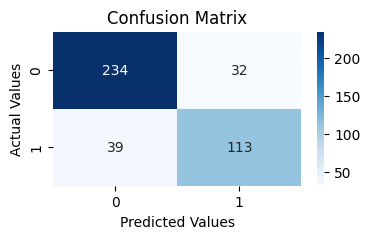

In [32]:
cm = confusion_matrix(y_test,y_pred)
plt.figure(figsize=(4,2))
plt.title("Confusion Matrix")
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.ylabel("Actual Values")
plt.xlabel("Predicted Values")

In [33]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.88      0.87       266
           1       0.78      0.74      0.76       152

    accuracy                           0.83       418
   macro avg       0.82      0.81      0.81       418
weighted avg       0.83      0.83      0.83       418



## Saving the Model

In [34]:
with open('model/model.pkl', 'wb') as f:
    pickle.dump(grid_search.best_estimator_, f)

## Saving the Data

In [35]:
x_train.to_csv('data/processed/x_train.csv', index=False)
x_test.to_csv('data/processed/x_test.csv', index=False)
y_train.to_csv('data/processed/y_train.csv', index=False)
y_test.to_csv('data/processed/y_test.csv', index=False)

## Saving the Predicted Values

In [36]:
results = pd.concat([pd.read_csv('data/external/new_y_test.csv').drop('Survived', axis=1), 
                     pd.DataFrame(y_pred, columns=['Survived'])], axis=1)
results.to_csv('data/predicted/predicted.csv', index=False)
results.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,1
4,896,0


In [37]:
os.chdir(old_path)

## Conclusions
- Added Model to the pipeline
- Tried various parameters using GridSearchCV
- Got the model with best performance using GridSearchCV
- Evaluated the Model's Performance